# Libraries and versions

In [146]:
#Basic libraries
python_version = !python -V #version 3.7.9
import pandas as pd #version 1.2.4
import numpy as np #version 1.20.1
import seaborn as sns #version 0.11.0
import matplotlib as plt #version 3.3.3

#for analyse multiple features
from sklearn import __version__ as skn #version 0.24.1
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#for model classifier
from lightgbm import LGBMClassifier

In [2]:
print(f'Python version - {python_version[0][7:]}')
print(f'Pandas version - {pd.__version__}')
print(f'Numpy version - {np.__version__}')
print(f'Seaborn version - {sns.__version__}')
print(f'Matplotlib version - {plt.__version__}')
print(f'Sklearn version - {skn}')

Python version - 3.7.9
Pandas version - 1.2.4
Numpy version - 1.20.1
Seaborn version - 0.11.0
Matplotlib version - 3.3.3
Sklearn version - 0.24.1


# Configurations

## Seaborn

In [125]:
sns.set_palette('inferno')
sns.set_style('darkgrid')

def configuration(graphic_object, title=None, xlabel=None, ylabel=None, colors='black'):
    graphic_object.figure.set_size_inches(15,8)
    graphic_object.set_title(title, color=colors, fontsize=16)
    graphic_object.set_xlabel(xlabel, color=colors, fontsize=14)
    graphic_object.set_ylabel(ylabel, color=colors, fontsize=14)
    graphic_object = graphic_object

## Warning

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Dataset

In [5]:
dataset = pd.read_csv('22_feature_selected.csv')
dataset.head()

,Net Income to Total Assets,Net worth/Assets,Persistent EPS in the Last Four Seasons,Retained Earnings to Total Assets,Net profit before tax/Paid-in capital,Per Share Net profit before tax (Yuan ¥),Working Capital to Total Assets,Net Income to Stockholder's Equity,Net Value Per Share (A),Operating Profit Per Share (Yuan ¥),...,Cash/Total Assets,Gross Profit to Sales,Equity to Long-term Liability,Current Liability to Equity,Liability to Equity,Current Liability to Current Assets,Borrowing dependency,Current Liability to Assets,Debt ratio %,Bankrupt
0,0.716845,0.792424,0.169141,0.903225,0.137757,0.138736,0.672775,0.827890,0.147950,0.095921,...,0.004094,0.601453,0.126549,0.339077,0.290202,0.118250,0.390284,0.147308,0.207576,1
1,0.795297,0.828824,0.208944,0.931065,0.168962,0.169918,0.751111,0.839969,0.182251,0.093722,...,0.014948,0.610237,0.120916,0.329740,0.283846,0.047775,0.376760,0.056963,0.171176,1
2,0.774670,0.792484,0.180581,0.909903,0.148036,0.142803,0.829502,0.836774,0.177911,0.092338,...,0.000991,0.601449,0.117922,0.334777,0.290189,0.025346,0.379093,0.098162,0.207516,1
3,0.739555,0.848535,0.193722,0.906902,0.147561,0.148603,0.725754,0.834697,0.154187,0.077762,...,0.018851,0.583538,0.120760,0.331509,0.281721,0.067250,0.379743,0.098715,0.151465,1
4,0.795016,0.893491,0.212537,0.913850,0.167461,0.168412,0.751822,0.839973,0.167502,0.096898,...,0.014161,0.598782,0.110933,0.330726,0.278514,0.047725,0.375025,0.110195,0.106509,1


## Select features

In [7]:
# total len of dataset
dataset.shape

(6819, 23)

### X and y

In [8]:
X = dataset.drop(columns=['Bankrupt'])
y = dataset['Bankrupt']

### SelectKBest

- the idea is search best number of features look for the best score in prediction

In [128]:
count = 1
total_score = []
bankrupt_predict = []
bankrupt_predict_score = []
n_features = []
for feature in range(X.shape[1]):
    #instance for feature selection (choose and transform)
    kbest = SelectKBest(score_func=chi2, k=count)
    X_kbest = kbest.fit_transform(X, y)

    #split data in train and test with different X
    X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, stratify=y, train_size=0.8, random_state=666)

    #trainning model
    lgbm_1 = LGBMClassifier(random_state=666)
    lgbm_1.fit(X_train, y_train)

    #predict y
    y_predict = lgbm_1.predict(X_test)

    #check accuracy
    total_accuracy = accuracy_score(y_test, y_predict) * 100

    #create a DataFram to count correct value predict for 1 in y_predict
    results = {'Test':y_test, 'Predict':y_predict}
    results = pd.DataFrame(results)
    results['OK'] = results['Test'] == results['Predict']
    bankrupt_accuracy = results.query('Predict==1 & OK==True').shape[0]
    bankrupt_total = results['Test'].sum()
    bankrupt_score = bankrupt_accuracy / bankrupt_total * 100

    #save data in dict
    total_score.append(total_accuracy)
    bankrupt_predict.append(bankrupt_accuracy)
    bankrupt_predict_score.append(bankrupt_score)
    n_features.append(count)
    
    #add one count
    count += 1
    
dict_results = {
    'Features':n_features, 
    'Total Score':total_score, 
    'Bankrupt Predict':bankrupt_predict,
    'Bankrupt Score':bankrupt_predict_score
}
lgbm_1_results = pd.DataFrame(data=dict_results)
lgbm_1_results

,Features,Total Score,Bankrupt Predict,Bankrupt Score
0,1,96.774194,0,0.000000
1,2,96.627566,1,2.272727
2,3,96.774194,5,11.363636
3,4,96.334311,4,9.090909
4,5,96.334311,5,11.363636
5,6,96.627566,6,13.636364
6,7,96.700880,7,15.909091
7,8,96.847507,4,9.090909
8,9,96.774194,4,9.090909
9,10,96.554252,5,11.363636


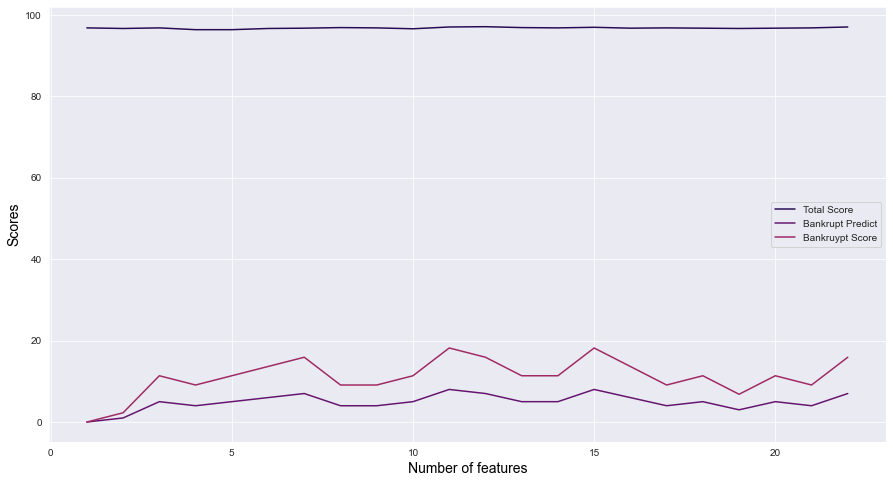

In [144]:
graphic1 = sns.lineplot(data=lgbm_1_results, x='Features', y='Total Score', label='Total Score')
graphic1 = sns.lineplot(data=lgbm_1_results, x='Features', y='Bankrupt Predict', label='Bankrupt Predict')
graphic1 = sns.lineplot(data=lgbm_1_results, x='Features', y='Bankrupt Score', label='Bankruypt Score')
configuration(graphic1, xlabel='Number of features', ylabel='Scores')